---
#### model 2 : LightGBM with feature engineering & Hyperparameter tunning
---

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel", 
              rc={"font.size": 9, "axes.titlesize": 9, "axes.labelsize": 9,
              "xtick.labelsize": 9, "ytick.labelsize": 9})  

#data loading
data_path = 'kaggle/input/porto-seguro-safe-driver-prediction/'
train = pd.read_csv(data_path + 'train.csv', index_col = 'id')
test = pd.read_csv(data_path + 'test.csv', index_col = 'id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col = 'id')

print(train.shape, test.shape, submission.shape)

(595212, 58) (892816, 57) (892816, 1)


In [2]:
#인코딩을 위한 데이터 합치기 
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1)
print(all_data.shape)

#전체 변수리스트 출력 
all_features = all_data.columns 
print(all_features)

(1488028, 57)
Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
  

--- 
#### Part 1. feature engineering 
   1. 명목변수 one-hot 인코딩 
   2. 결측값의 갯수를 하나의 변수로 생성하여 추가 
   3. 명목형과 cat형 변수를 제외한 remaining features 정의 
   4. 명목형 변수들(cat, mix_ind)의 모든 고유값별 갯수를, 새로운 파생변수로 변환 
   5. 위 1~4에서 생성된 변수들을 결합한 데이터셋 생성 
   6. 데이터셋을 다시 train/test 데이터로 분리 
---

In [3]:
#nominal features --> one-hot encoding 
from sklearn.preprocessing import OneHotEncoder
cat_features = [feature for feature in all_features if 'cat' in feature]
print(cat_features) 

onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features])
encoded_cat_matrix

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']


<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

In [4]:
all_data.head().T

,0,1,2,3,4
ps_ind_01,2.000000,1.000000,5.000000,0.000000,0.000000
ps_ind_02_cat,2.000000,1.000000,4.000000,1.000000,2.000000
ps_ind_03,5.000000,7.000000,9.000000,2.000000,0.000000
ps_ind_04_cat,1.000000,0.000000,1.000000,0.000000,1.000000
ps_ind_05_cat,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_06_bin,0.000000,0.000000,0.000000,1.000000,1.000000
ps_ind_07_bin,1.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_08_bin,0.000000,1.000000,1.000000,0.000000,0.000000
ps_ind_09_bin,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_10_bin,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
#결측값 갯수를 파생변수로 
all_data['num_missing'] = (all_data == -1).sum(axis=1)

In [6]:
#remaining_features 정의 : nominal, calc이 아닌 변수
remaining_features = [feature for feature in all_features
                      if ('cat' not in feature and 'calc' not in feature) ]

#결측값 파생변수(num_minning) 추가
remaining_features.append('num_missing')

print(remaining_features)

['ps_ind_01', 'ps_ind_03', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'num_missing']


In [7]:
#모든 ind 변수들의 값을 _로 연결한 mix_ind 생성 
ind_features = [feature for feature in all_features
                if 'ind' in feature] 
print(ind_features)

is_first_feature = True 
for ind_feature in ind_features : 
    if is_first_feature : 
        all_data['mix_ind'] = all_data[ind_feature].astype(str) + '_'
        is_first_feature = False
    else : 
        all_data['mix_ind'] += all_data[ind_feature].astype(str) + '_'


all_data['mix_ind']       


['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin']


0          2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
1488023     0_1_6_0_0_0_1_0_0_0_0_0_0_0_2_0_0_1_
1488024    5_3_5_1_0_0_0_1_0_0_0_0_0_0_11_1_0_0_
1488025     0_1_5_0_0_1_0_0_0_0_0_0_0_0_5_0_0_1_
1488026    6_1_5_1_0_0_0_0_1_0_0_0_0_0_13_1_0_0_
1488027    7_1_4_1_0_0_0_0_1_0_0_0_0_0_12_1_0_0_
Name: mix_ind, Length: 1488028, dtype: object

In [8]:
#명목형 변수들(cat, mix_ind)의 고유값별 갯수를 파생변수로 만들기 
cat_count_features = []
for feature in cat_features+['mix_ind'] :
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x : val_counts_dict[x])
    cat_count_features.append(f'{feature}_count')

cat_count_features    

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'mix_ind_count']

- 생성된 변수들 
  1) encoded_cat_matrix : 원핫 인코딩된 명목변수 
  2) remaining_features : 명목형과 calc분류를 제외한 변수들 (num_missing 변수 추가)
  3) cat_count_featues : max_ind를 포함한 명목평 변수들의 고유값별 갯수 

In [9]:
#불필요한 변수들 제거하고, 데이터 합치기 
from scipy import sparse 

drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']
all_data_remaining = all_data[remaining_features + cat_count_features].drop(drop_features, axis=1)

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining), 
                               encoded_cat_matrix], format = 'csr')

In [10]:
all_data_sprs

<1488028x217 sparse matrix of type '<class 'numpy.float64'>'
	with 61125924 stored elements in Compressed Sparse Row format>

In [11]:
#다시 train/test 데이터 분리 
num_train = len(train)

X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]
y = train['target'].values

print(X.shape, X_test.shape, y.shape)

(595212, 217) (892816, 217) (595212,)


---
#### 2. Hyper parameter tunning : Bayesian optimizing 
 - Grid search 보다 속도와 성능, 직관적인 코드 구성이 장점 
---

In [12]:
#Bayesin을 위한 훈련 및 검증용 데이터셋 구성 
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train,X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

bayes_dtrain = lgb.Dataset(X_train, y_train)
bayes_dvalid = lgb.Dataset(X_valid, y_valid)

In [13]:
#파라미터 범위 
param_bounds = {'num_leaves': (30,40), 
                'lambda_l1':(0.7, 0.9), 
                'lambda_l2':(0.9, 1),
                'feature_fraction': (0.6, 0.7), 
                'bagging_fraction': (0.6, 0.9), 
                'min_child_samples': (6, 10), 
                'min_child_weight': (10, 40) }

#고정값
fixed_params = {'objective': 'binary', 
                'learning_rate': 0.005,    ##보통 0.01~0.001 사이에서 지정, 속도를 위해 임의 지정함 
                'bagging_freq': 1,         ##배깅빈도 1  
                'force_row_wise': True, 
                'random_state' : 1991 
                 }

In [14]:
# LightGBM용 gini() 함수 : 신백균 제공: https://www.kaggle.com/code/werooring/ch8-lgb-modeling
def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True # 반환값

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [15]:
def eval_function(num_leaves, lambda_l1, lambda_l2, feature_fraction,
                  bagging_fraction, min_child_samples, min_child_weight):
    '''최적화하려는 평가지표(지니계수) 계산 함수'''
    
    # 베이지안 최적화를 수행할 하이퍼파라미터 
    params = {'num_leaves': int(round(num_leaves)),   ##최대 가지수
              'lambda_l1': lambda_l1,                 ##정규화 강도
              'lambda_l2': lambda_l2,
              'feature_fraction': feature_fraction,   ##각 트리마다 사용될 피처의 비율. 일종의 피처 샘플링을 제어하는 매개변수
              'bagging_fraction': bagging_fraction,   ##부스팅 과정에서 각 반복마다 사용될 데이터 샘플링 비율
              'min_child_samples': int(round(min_child_samples)),   ##리프 노드가 되기 위한 최소 데이터 샘플 수입니다. 정수형 값으로 반올림하여 설정
              'min_child_weight': min_child_weight,                 ##리프 노드가 되기 위한 최소 가중치 합. 일반적으로 데이터 샘플 가중치의 합을 제한하기 위해 사용
              'feature_pre_filter': False}                          ##LightGBM 모델에서 사용할 피처의 사전 필터링을 사용할지 여부를 결정하는 매개변수
    # 고정된 하이퍼파라미터도 추가
    params.update(fixed_params)
    
    print('하이퍼파라미터:', params)    
    
    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=params, 
                          train_set=bayes_dtrain,
                          num_boost_round=2500,
                          valid_sets=bayes_dvalid,
                          feval=gini,
                          callbacks=[
                             lgb.early_stopping(stopping_rounds=300),
                             lgb.log_evaluation(period=100)  #100번째 반복마다 로그 출력
                             ])


    # 검증 데이터로 예측 수행
    preds = lgb_model.predict(X_valid) 
    # 지니계수 계산
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')
    
    return gini_score

In [16]:
#베이지안 최적화 객체 생성 
#!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(f=eval_function, 
                                 pbounds = param_bounds,
                                 random_state = 0)

In [17]:
import time
start_time = time.time()

#베이지안 최적화 실행 
optimizer.maximize(init_points = 3, n_iter=6)

end_time = time.time()
execution_time = end_time - start_time
print(f"코드실행 시간: {execution_time} seconds")

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | min_ch... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
하이퍼파라미터: {'num_leaves': 34, 'lambda_l1': 0.8205526752143287, 'lambda_l2': 0.9544883182996897, 'feature_fraction': 0.6715189366372419, 'bagging_fraction': 0.7646440511781974, 'min_child_samples': 8, 'min_child_weight': 29.376823391999682, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 1991}
[LightGBM] [Info] Number of positive: 17383, number of negative: 458786
[LightGBM] [Info] Total Bins 1555
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036506 -> initscore=-3.273091
[LightGBM] [Info] Start training from score -3.273091
Training until validation scores don't improve for 300 rounds
[100

In [18]:
#optimized parameters 
max_params = optimizer.max['params']
max_params

{'bagging_fraction': 0.6626247133728974,
 'feature_fraction': 0.6126817698209742,
 'lambda_l1': 0.8268138957114485,
 'lambda_l2': 0.9,
 'min_child_samples': 9.761611657760122,
 'min_child_weight': 35.87746477712849,
 'num_leaves': 32.800739086810694}

In [19]:
# num_leaves, min_child_samples는 정수이므로 정수변환 
max_params['num_leaves'] = int(round(max_params['num_leaves']))
max_params['min_child_samples'] = int(round(max_params['min_child_samples']))

# fixed parameters add 
max_params.update(fixed_params)

#최종 파라미터 출력 
max_params

{'bagging_fraction': 0.6626247133728974,
 'feature_fraction': 0.6126817698209742,
 'lambda_l1': 0.8268138957114485,
 'lambda_l2': 0.9,
 'min_child_samples': 10,
 'min_child_weight': 35.87746477712849,
 'num_leaves': 33,
 'objective': 'binary',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'force_row_wise': True,
 'random_state': 1991}

---
#### 최종 파라미터로 모델훈련 및 검증 

In [23]:
from sklearn.model_selection import StratifiedKFold

#k-fold = 5
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

#훈련된 모델의 검증/테스트 타겟값을 담을 배열 
oof_val_preds = np.zeros(X.shape[0])
oof_test_preds = np.zeros(X_test.shape[0])

#model train, predict, validation 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X,y)): 
    print("#"*50, f'fold {idx+1} / fold {folds.n_splits}', "#"*50)

    X_train, y_train = X[train_idx], y[train_idx]    ##train data
    X_valid, y_valid = X[valid_idx], y[valid_idx]    ##valid data

    dtrain = lgb.Dataset(X_train, y_train)           ##LightGBM용 train data
    dvalid = lgb.Dataset(X_valid, y_valid)           ##LightGBM용 valid data

    #LightGBM model training 
    lgb_model = lgb.train(params = max_params, 
                          train_set = dtrain, 
                          num_boost_round = 2500, 
                          valid_sets = dvalid, 
                          feval = gini, 
                          callbacks=[
                             lgb.early_stopping(stopping_rounds=300),
                             lgb.log_evaluation(period=100)  #100번째 반복마다 로그 출력
                             ] )
    
    #모델의 예측값 
    oof_test_preds += lgb_model.predict(X_test) / folds.n_splits
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)

    #정규화 gini score 
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'fold {idx+1} gini_score: {gini_score} \n')

################################################## fold 1 / fold 5 ##################################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 300 rounds
[100]	valid_0's binary_logloss: 0.154293	valid_0's gini: 0.268452
[200]	valid_0's binary_logloss: 0.153249	valid_0's gini: 0.273856
[300]	valid_0's binary_logloss: 0.15265	valid_0's gini: 0.278185
[400]	valid_0's binary_logloss: 0.15229	valid_0's gini: 0.281623
[500]	valid_0's binary_logloss: 0.152051	valid_0's gini: 0.284844
[600]	valid_0's binary_logloss: 0.151891	valid_0's gini: 0.287294
[700]	valid_0's binary_logloss: 0.151783	valid_0's gini: 0.289035
[800]	valid_0's binary_lo

In [26]:
#결과 제출 
print('gini_score_valid = ', eval_gini(y, oof_val_preds))
print('gini_score_test = ', oof_test_preds)

submission['target'] = oof_test_preds
submission.to_csv('submission.csv')

gini_score_valid =  0.2888026261834394
gini_score_test =  [0.02680365 0.02346368 0.02330406 ... 0.03454174 0.02150611 0.02828947]


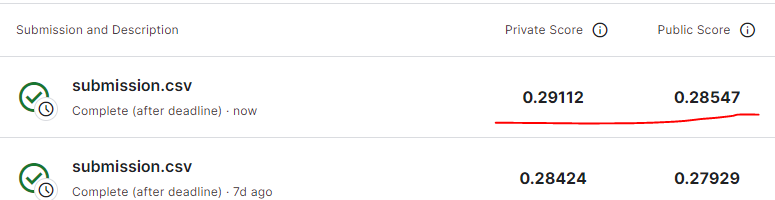

In [27]:
from IPython.display import Image
Image("images/gini_2.PNG")